# Measuring the accuracy of random and stratified sampling for predicting the prevalence

We compare the predictions of infected individuals for the following sampling strategies in EpiOS:
- Random
- Age stratification
- Region stratification

Imports

In [258]:
import epios

from typing import List, Tuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

In [259]:
path = '.'
# This assumes the python venv is installed under EpiOS folder
demo_data = pd.read_csv(f'{path}/simulation_outputs/demographics.csv')
time_data = pd.read_csv(f'{path}/simulation_outputs/inf_status_history.csv')

In [260]:
def predict_base(post_process: epios.PostProcess, sample_size: int,
                 time_sample: List[int], comparison: bool,
                 sample_strategy: str) -> Tuple[np.array, ...]:
    """Uses the `Base` method from `epios.PostProcess` to predict prevalence
    from a sample.

    Returns
    -------
    Tuple[np.array, ...]
         Returns the times, true and predicted incidence rates in a tuple to be
         used for further analysis
    """
    # Make prediction
    result, diff = post_process.predict.Base(sample_size=sample_size,
                                             time_sample=time_sample,
                                             comparison=comparison,
                                             gen_plot=False,
                                             sample_strategy=sample_strategy)

    # Find population size and get true data
    pop_size = len(post_process.demo_data)
    times, base_prediction = result[0], np.array(result[1]) * pop_size
    true = diff + base_prediction
    base_prediction_age_groups = post_process.predict.result_ages
    base_prediction_regions = post_process.predict.result_regions

    return times, true, base_prediction, base_prediction_age_groups, base_prediction_regions

In [261]:
def predict_age(post_process: epios.PostProcess, sample_size: int,
                 time_sample: List[int], comparison: bool,
                 sample_strategy: str) -> Tuple[np.array, ...]:
    """Uses the `Age` method from `epios.PostProcess` to predict prevalence
    from a sample.

    Returns
    -------
    Tuple[np.array, ...]
         Returns the times, true and predicted incidence rates in a tuple to be
         used for further analysis
    """
    # Make prediction
    result, diff = post_process.predict.Age(sample_size=sample_size,
                                             time_sample=time_sample,
                                             comparison=comparison,
                                             gen_plot=False,
                                             sample_strategy=sample_strategy)

    # Find population size and get true data
    pop_size = len(post_process.demo_data)
    times, age_prediction = result[0], np.array(result[1]) * pop_size
    true = diff + age_prediction
    age_prediction_age_groups = post_process.predict.result_ages
    age_prediction_regions = post_process.predict.result_regions

    return times, true, age_prediction, age_prediction_age_groups, age_prediction_regions

In [262]:
def predict_region(post_process: epios.PostProcess, sample_size: int,
                 time_sample: List[int], comparison: bool,
                 sample_strategy: str) -> Tuple[np.array, ...]:
    """Uses the `Region` method from `epios.PostProcess` to predict prevalence
    from a sample.

    Returns
    -------
    Tuple[np.array, ...]
         Returns the times, true and predicted incidence rates in a tuple to be
         used for further analysis
    """
    # Make prediction
    result, diff = post_process.predict.Region(sample_size=sample_size,
                                             time_sample=time_sample,
                                             comparison=comparison,
                                             gen_plot=False,
                                             sample_strategy=sample_strategy)

    # Find population size and get true data
    pop_size = len(post_process.demo_data)
    times, region_prediction = result[0], np.array(result[1]) * pop_size
    true = diff + region_prediction
    region_prediction_age_groups = post_process.predict.result_ages
    region_prediction_regions = post_process.predict.result_regions

    return times, true, region_prediction, region_prediction_age_groups, region_prediction_regions

### Finding samples using Random, Age, and Region methods

In [263]:
def rand(post_process: epios.PostProcess, sample_size: int,
                  time_sample: List[int], comparison: bool) -> Tuple[np.array, ...]:
    """This returns predictions from the Random sampling strategies,
    without plotting. These will be averaged over multiple runs

    Returns
    -------
    Tuple[np.array, ...]
        Times array, true results, predictions with Random strategy
    """
    # Do prediction and comparison with Random sampling strategy - this samples
    # different people every time step
    random = predict_base(post_process=post_process,
                               sample_size=sample_size,
                               time_sample=time_sample,
                               comparison=comparison,
                               sample_strategy='Random')
    times, true, base_pred, base_pred_age_groups, base_pred_regions = random

    return times, true, base_pred, base_pred_age_groups, base_pred_regions

In [264]:
def age(post_process: epios.PostProcess, sample_size: int,
                  time_sample: List[int], comparison: bool) -> Tuple[np.array, ...]:
    """This returns predictions from the age stratification, without plotting.
    These will be averaged over multiple runs

    Returns
    -------
    np.array
        Predictions with Random strategy
    """
    # Do prediction and comparison with Random sampling strategy - this samples
    # different people every time step
    age_strat = predict_age(post_process=post_process,
                               sample_size=sample_size,
                               time_sample=time_sample,
                               comparison=comparison,
                               sample_strategy='Random')
    times, true, age_pred, age_pred_age_groups, age_pred_regions = age_strat

    return times, true, age_pred, age_pred_age_groups, age_pred_regions

In [265]:
def region(post_process: epios.PostProcess, sample_size: int,
                  time_sample: List[int], comparison: bool) -> Tuple[np.array, ...]:
    """This returns predictions from the region stratification,
    without plotting. These will be averaged over multiple runs

    Returns
    -------
    Tuple[np.array, ...]
        Times array, true results, predictions with Random strategy
    """
    # Do prediction and comparison with Random sampling strategy - this samples
    # different people every time step
    region = predict_region(post_process=post_process,
                            sample_size=sample_size,
                            time_sample=time_sample,
                            comparison=comparison,
                            sample_strategy='Random')
    times, true, region_pred, region_pred_age_groups, region_pred_regions = region

    return times, true, region_pred, region_pred_age_groups, region_pred_regions

### Calculating the true number of infections per age group

In [266]:
def count_people_by_age_group(demo_data, time_data, time_sample, num_age_group=17, age_group_width=5):
    """
    Count the true number of people within each age group that are infected.

    Parameters
    ----------
    demo_data: pandas.DataFrame
        Demographic data of the population
    time_data: pandas.DataFrame
        The infection data of the population at different time points
    time_sample: list
        A list of time points to sample the population
    num_age_group: int
        Number of age groups within the population
    age_group_width: int
        Number of ages within an age group

    Returns
    -------
    total_infections_age_groups: list[list, ...]
        A list containing a list of infection totals for each time point. Here,
        each list represents an age group
    total_by_age: list
        A list containing the total number of individuals in each age group
    """
    df = demo_data
    inf_history = time_data
    total_infections_age_groups = []
    total_by_age = []

    # Group data by age groups
    for i in range(num_age_group):
        min_age = i * age_group_width
        max_age = min_age + age_group_width
        if i == num_age_group - 1:
            max_age = float('inf')  # Last group includes age >= some threshold

        age_group_data = df[df['age'].between(min_age, max_age-0.01)]

        selected_columns = [col for col in inf_history.columns if str(col) in age_group_data['id'].astype(str).values]
        selected_data = inf_history[selected_columns]

        selected_data = selected_data.iloc[time_sample]

        people_by_age = len(selected_data.columns)
        infections_by_age_group = selected_data.apply(lambda row: row.isin(range(3, 9)).sum(), axis=1).tolist()
        total_infections_age_groups.append(infections_by_age_group)
        total_by_age.append(people_by_age)

    return total_infections_age_groups, total_by_age

### Calculating the true number of infections per region

In [267]:
def count_people_by_region(demo_data, time_data, time_sample):
    """
    Count the true number of people within each region that are infected.

    Parameters
    ----------
    demo_data: pandas.DataFrame
        Demographic data of the population
    time_data: pandas.DataFrame
        The infection data of the population at different time points
    time_sample: list
        A list of time points to sample the population

    Returns
    -------
    total_count_regions: list[list, ...]
        A list containing a list of infection totals for each time point. Here,
        each list represents a region
    total_by_region: list
        A list containing the total number of individuals in each region
    """
    inf_history = time_data
    last_row = demo_data.iloc[-1]
    region_id = int(last_row['id'].split('.')[0])
    total_by_region = []
    total_count_regions = []
    for region in range(region_id + 1):
        region_columns = [col for col in inf_history.columns if str(col).startswith(f'{region}.')]
        selected_data = inf_history[region_columns]
        selected_data = selected_data.iloc[time_sample]
        count_regions = selected_data.apply(lambda row: row.isin(range(3, 9)).sum(), axis=1).tolist()
        total_count_regions.append(count_regions)
        total_by_region.append(len(inf_history[region_columns].columns))

    return total_count_regions, total_by_region

In [268]:
time_sample = [num for num in range(300)]
true_age_grouped_infections, total_by_age_groups = count_people_by_age_group(demo_data, time_data, time_sample)
true_regional_infections, total_by_region = count_people_by_region(demo_data, time_data, time_sample)

### Initialising the post process

In [269]:
post_process = epios.PostProcess(demo_data=demo_data, time_data=time_data)

# Initialise the predictions
base_pred_iterations = []
age_pred_iterations = []
region_pred_iterations = []
age_grouped_results = []
regional_results = []


### Here will we find the total prediction and the stratified predictions

In [270]:
num_iters = 50
start_time = time.time()
for j in range(num_iters):
    predictions = rand(post_process=post_process,
                       sample_size=10,
                       time_sample=time_sample,
                       comparison=True)
    times, true, base_pred, base_pred_age_groups, base_pred_regions = predictions

    age_predictions = age(post_process=post_process,
                          sample_size=10,
                          time_sample=time_sample,
                          comparison=True)
    age_pred, age_pred_age_groups, age_pred_regions = age_predictions[2], age_predictions[3], age_predictions[4]

    region_predictions = region(post_process=post_process,
                                sample_size=10,
                                time_sample=time_sample,
                                comparison=True)
    region_pred, region_pred_age_groups, region_pred_regions = region_predictions[2], region_predictions[3], region_predictions[4]

    print(f"Iteration {j}")

    base_pred_iterations.append(np.array(base_pred))
    age_pred_iterations.append(np.array(age_pred))
    region_pred_iterations.append(np.array(region_pred))

    # Create a dictionary representing the iteration result
    iteration_age_result = {'Iteration': j,
                        'Base Prediction': np.array(base_pred_age_groups, dtype='float64'),
                        'Age Prediction': np.array(age_pred_age_groups, dtype='float64'),
                        'Region Prediction': np.array(region_pred_age_groups, dtype='float64')}

    # Append the iteration result to the list
    if j >= len(age_grouped_results):
        age_grouped_results.append(iteration_age_result)

    iteration_region_result = {'Iteration': j,
                        'Base Prediction': np.array(base_pred_regions, dtype='float64'),
                        'Age Prediction': np.array(age_pred_regions, dtype='float64'),
                        'Region Prediction': np.array(region_pred_regions, dtype='float64')}

    if j >= len(regional_results):
        regional_results.append(iteration_region_result)

age_results_df = pd.DataFrame(age_grouped_results)
regional_results_df = pd.DataFrame(regional_results)

Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49


### Averaging the predictions across the 50 iterations

Base predictions

In [271]:
base_pred_array = np.zeros_like(base_pred_iterations[0])

for arr in base_pred_iterations:
    base_pred_array += arr
base_pred_array = base_pred_array / num_iters
base_pred_avg = base_pred_array.tolist()


Age stratified predictions

In [272]:
age_pred_array = np.zeros_like(age_pred_iterations[0])

for arr in age_pred_iterations:
    age_pred_array += arr
age_pred_array = age_pred_array / num_iters
age_pred_avg = age_pred_array.tolist()

Region stratified predictions

In [273]:
region_pred_array = np.zeros_like(region_pred_iterations[0])

for arr in region_pred_iterations:
    region_pred_array += arr
region_pred_array = region_pred_array / num_iters
region_pred_avg = region_pred_array.tolist()

### Saving to .csv files

In [ ]:
import os
cwd = os.getcwd()

In [274]:
true_total = pd.DataFrame(true)
true_age_grouped_infections = pd.DataFrame(true_age_grouped_infections)
true_regional_infections = pd.DataFrame(true_regional_infections)
total_by_age_groups = pd.DataFrame(total_by_age_groups)
total_by_region = pd.DataFrame(total_by_region)
base_pred_iterations = pd.DataFrame(base_pred_iterations)
age_pred_iterations = pd.DataFrame(age_pred_iterations)
region_pred_iterations = pd.DataFrame(region_pred_iterations)

true_total.to_csv(f'{cwd}/random_strategy/true_total_infections_10.csv')
true_age_grouped_infections.to_csv(f'{cwd}/random_strategy/true_infections_age_group_10.csv')
true_regional_infections.to_csv(f'{cwd}/random_strategy/true_infections_regions_10.csv')
total_by_age_groups.to_csv(f'{cwd}/random_strategy/total_by_age_group_10.csv')
total_by_region.to_csv(f'{cwd}/random_strategy/total_by_regions_10.csv')
base_pred_iterations.to_csv(f'{cwd}/random_strategy/predictions_10.csv')
age_pred_iterations.to_csv(f'{cwd}/age_strategy/predictions_10.csv')
region_pred_iterations.to_csv(f'{cwd}/region_strategy/predictions_10.csv')
age_results_df.to_csv(f'{cwd}/age_strategy/predictions_by_age_10.csv')
regional_results_df.to_csv(f'{cwd}/region_strategy/predictions_by_region_10.csv')

### Reading from .csv files

In [282]:
import pandas as pd
from itertools import chain

true_age_grouped_infections = pd.read_csv(f'{cwd}/random_strategy/true_infections_age_group_10.csv')
true_age_grouped_lists = true_age_grouped_infections.iloc[:, 1:].values.tolist()

true_region_infections = pd.read_csv(f'{cwd}/random_strategy/true_infections_regions_10.csv')
true_region_lists = true_region_infections.iloc[:, 1:].values.tolist()

total_by_age_groups = pd.read_csv(f'{cwd}/random_strategy/total_by_age_group_10.csv')
total_by_age_groups_lists = list(chain.from_iterable(total_by_age_groups.iloc[:, 1:].values.tolist()))

total_by_region = pd.read_csv(f'{cwd}/random_strategy/total_by_regions_10.csv')
total_by_region_lists = list(chain.from_iterable(total_by_region.iloc[:, 1:].values.tolist()))

base_pred_infections = pd.read_csv(f'{cwd}/random_strategy/predictions_10.csv')
base_pred_lists = base_pred_infections.iloc[:, 1:].values.tolist()

age_pred_infections = pd.read_csv(f'{cwd}/age_strategy/predictions_10.csv')
age_pred_lists = age_pred_infections.iloc[:, 1:].values.tolist()

region_pred_infections = pd.read_csv(f'{cwd}/region_strategy/predictions_10.csv')
region_pred_lists = region_pred_infections.iloc[:, 1:].values.tolist()

# age_results_df = pd.read_csv(f'{cwd}/age_strategy/predictions_by_age_10.csv', index_col=False)
# regional_results_df = pd.read_csv(f'{cwd}/region_strategy/predictions_by_region_10.csv', index_col=False, escapechar='\\')


### Calculating RMSE

Age predictions

In [ ]:
base_rmse_list = []
age_rmse_list = []
region_rmse_list = []
base_avg_rmse_age = []
age_avg_rmse_age = []
region_avg_rmse_age = []
base_norm_rmse_age = []
age_norm_rmse_age = []
region_norm_rmse_age = []

mean_age = [np.mean(sublist) for sublist in true_age_grouped_lists]

for row in age_results_df['Base Prediction']:
    aged = [sublist * total_by_age_groups_lists[i] for i, sublist in enumerate(row)]
    sublist_rmse = [np.sqrt(np.mean((np.array(total)-np.array(sublist))**2)) for sublist, total in zip(aged, true_age_grouped_lists)]
    base_rmse_list.append(sublist_rmse)

base_rmse_df = pd.DataFrame(base_rmse_list)
base_rmse_df_norm = base_rmse_df.div(mean_age, axis=1)

for column in range(len(age_results_df['Base Prediction'][0])):
    base_avg_rmse_age.append(np.mean(base_rmse_df.iloc[:, column]))
    base_norm_rmse_age.append(np.mean(base_rmse_df_norm.iloc[:, column]))

for row in age_results_df['Age Prediction']:
    aged = [sublist * total_by_age_groups_lists[i] for i, sublist in enumerate(row)]
    sublist_rmse = [np.sqrt(np.mean((np.array(total)-np.array(sublist))**2)) for sublist, total in zip(aged, true_age_grouped_lists)]
    age_rmse_list.append(sublist_rmse)

age_rmse_df = pd.DataFrame(age_rmse_list)
age_rmse_df_norm = age_rmse_df.div(mean_age, axis=1)

for column in range(len(age_results_df['Age Prediction'][0])):
    age_avg_rmse_age.append(np.mean(age_rmse_df.iloc[:, column]))
    age_norm_rmse_age.append(np.mean(age_rmse_df_norm.iloc[:, column]))

for row in age_results_df['Region Prediction']:
    aged = [sublist * total_by_age_groups_lists[i] for i, sublist in enumerate(row)]
    sublist_rmse = [np.sqrt(np.mean((np.array(total)-np.array(sublist))**2)) for sublist, total in zip(aged, true_age_grouped_lists)]
    region_rmse_list.append(sublist_rmse)

region_rmse_df = pd.DataFrame(region_rmse_list)
region_rmse_df_norm = region_rmse_df.div(mean_age, axis=1)

for column in range(len(age_results_df['Region Prediction'][0])):
    region_avg_rmse_age.append(np.mean(region_rmse_df.iloc[:, column]))
    region_norm_rmse_age.append(np.mean(region_rmse_df_norm.iloc[:, column]))

base_std_age = base_rmse_df.std(axis=0).tolist()
age_std_age = age_rmse_df.std(axis=0).tolist()
region_std_age = region_rmse_df.std(axis=0).tolist()

print(base_avg_rmse_age)
print(age_avg_rmse_age)
print(region_avg_rmse_age)

d = np.mean(age_results_df['Base Prediction'], axis=0)
# Multiply each sublist by the total number of people in that age group
aged = [sublist * total_by_age_groups_lists[i] for i, sublist in enumerate(d)]
sublist_rmse = [np.sqrt(((np.array(total)-np.array(sublist))**2).mean()) for sublist, total in zip(aged, true_age_grouped_lists)]
print(sublist_rmse)

d = np.mean(age_results_df['Age Prediction'], axis=0)
# Multiply each sublist by the total number of people in that age group
aged = [sublist * total_by_age_groups_lists[i] for i, sublist in enumerate(d)]
sublist_rmse = [np.sqrt(((np.array(total)-np.array(sublist))**2).mean()) for sublist, total in zip(aged, true_age_grouped_lists)]
print(sublist_rmse)

d = np.mean(age_results_df['Region Prediction'], axis=0)
# Multiply each sublist by the total number of people in that age group
aged = [sublist * total_by_age_groups_lists[i] for i, sublist in enumerate(d)]
sublist_rmse = [np.sqrt(((np.array(total)-np.array(sublist))**2).mean()) for sublist, total in zip(aged, true_age_grouped_lists)]
print(sublist_rmse)

Regional predictions

In [ ]:
base_rmse_list = []
age_rmse_list = []
region_rmse_list = []
base_avg_rmse_region = []
age_avg_rmse_region = []
region_avg_rmse_region = []
base_norm_rmse_region = []
age_norm_rmse_region = []
region_norm_rmse_region = []

mean_region = [np.mean(sublist) for sublist in true_region_lists]

for row in regional_results_df['Base Prediction']:
    aged = [sublist * total_by_region_lists[i] for i, sublist in enumerate(row)]
    sublist_rmse = [np.sqrt(((np.array(total)-np.array(sublist))**2).mean()) for sublist, total in zip(aged, true_region_lists)]
    base_rmse_list.append(sublist_rmse)

base_rmse_df = pd.DataFrame(base_rmse_list)
base_rmse_df_norm = base_rmse_df.div(mean_region, axis=1)

for column in range(len(regional_results_df['Base Prediction'][0])):
    base_avg_rmse_region.append(np.mean(base_rmse_df.iloc[:, column]))
    base_norm_rmse_region.append(np.mean(base_rmse_df_norm.iloc[:, column]))


for row in regional_results_df['Age Prediction']:
    aged = [sublist * total_by_region_lists[i] for i, sublist in enumerate(row)]
    sublist_rmse = [np.sqrt(((np.array(total)-np.array(sublist))**2).mean()) for sublist, total in zip(aged, true_region_lists)]
    age_rmse_list.append(sublist_rmse)

age_rmse_df = pd.DataFrame(age_rmse_list)
age_rmse_df_norm = age_rmse_df.div(mean_region, axis=1)

for column in range(len(regional_results_df['Age Prediction'][0])):
    age_avg_rmse_region.append(np.mean(age_rmse_df.iloc[:, column]))
    age_norm_rmse_region.append(np.mean(age_rmse_df_norm.iloc[:, column]))

for row in regional_results_df['Region Prediction']:
    aged = [sublist * total_by_region_lists[i] for i, sublist in enumerate(row)]
    sublist_rmse = [np.sqrt(((np.array(total)-np.array(sublist))**2).mean()) for sublist, total in zip(aged, true_region_lists)]
    region_rmse_list.append(sublist_rmse)

region_rmse_df = pd.DataFrame(region_rmse_list)
region_rmse_df_norm = region_rmse_df.div(mean_region, axis=1)

for column in range(len(regional_results_df['Region Prediction'][0])):
    region_avg_rmse_region.append(np.mean(region_rmse_df.iloc[:, column]))
    region_norm_rmse_region.append(np.mean(region_rmse_df_norm.iloc[:, column]))

base_std_region = base_rmse_df.std(axis=0).tolist()
age_std_region = age_rmse_df.std(axis=0).tolist()
region_std_region = region_rmse_df.std(axis=0).tolist()

print(base_avg_rmse_region)
print(age_avg_rmse_region)
print(region_avg_rmse_region)


Total infection predictions

In [ ]:
base_pred_array = np.zeros_like(base_pred_lists[0])
age_pred_array = np.zeros_like(age_pred_lists[0])
region_pred_array = np.zeros_like(region_pred_lists[0])
base_pred_rmse = []
age_pred_rmse = []
region_pred_rmse = []

for arr in base_pred_lists:
    base_pred_array += arr
    base_pred_rmse.append(np.sqrt(((true-arr)**2).mean()))
base_pred_array = base_pred_array / num_iters
base_pred_avg = base_pred_array.tolist()
print(base_pred_rmse)

for arr in age_pred_lists:
    age_pred_array += arr
    age_pred_rmse.append(np.sqrt(((true-arr)**2).mean()))
age_pred_array = age_pred_array / num_iters
age_pred_avg = age_pred_array.tolist()
print(age_pred_rmse)

for arr in region_pred_lists:
    region_pred_array += arr
    region_pred_rmse.append(np.sqrt(((true-arr)**2).mean()))
region_pred_array = region_pred_array / num_iters
region_pred_avg = region_pred_array.tolist()
print(region_pred_rmse)



### Calculating the confidence interval of the predictions

In [503]:
print(len(base_pred_lists)) # Number of iterations

base_std_deviation = (np.std(np.array(base_pred_lists), axis=0))
age_std_deviation = (np.std(np.array(age_pred_lists), axis=0))
region_std_deviation = (np.std(np.array(region_pred_lists), axis=0))

base_confidence_interval_upper = (np.array(base_pred_avg) + (1.96 * base_std_deviation / np.sqrt(50))).tolist()
base_confidence_interval_lower = (np.array(base_pred_avg) - (1.96 * base_std_deviation / np.sqrt(50))).tolist()
age_confidence_interval_upper = (np.array(age_pred_avg) + (1.96 * age_std_deviation / np.sqrt(50))).tolist()
age_confidence_interval_lower = (np.array(age_pred_avg) - (1.96 * age_std_deviation / np.sqrt(50))).tolist()
region_confidence_interval_upper = (np.array(region_pred_avg) + (1.96 * region_std_deviation / np.sqrt(50))).tolist()
region_confidence_interval_lower = (np.array(region_pred_avg) - (1.96 * region_std_deviation / np.sqrt(50))).tolist()


50


## Plots

Here we are plotting the true infection total against the prediction

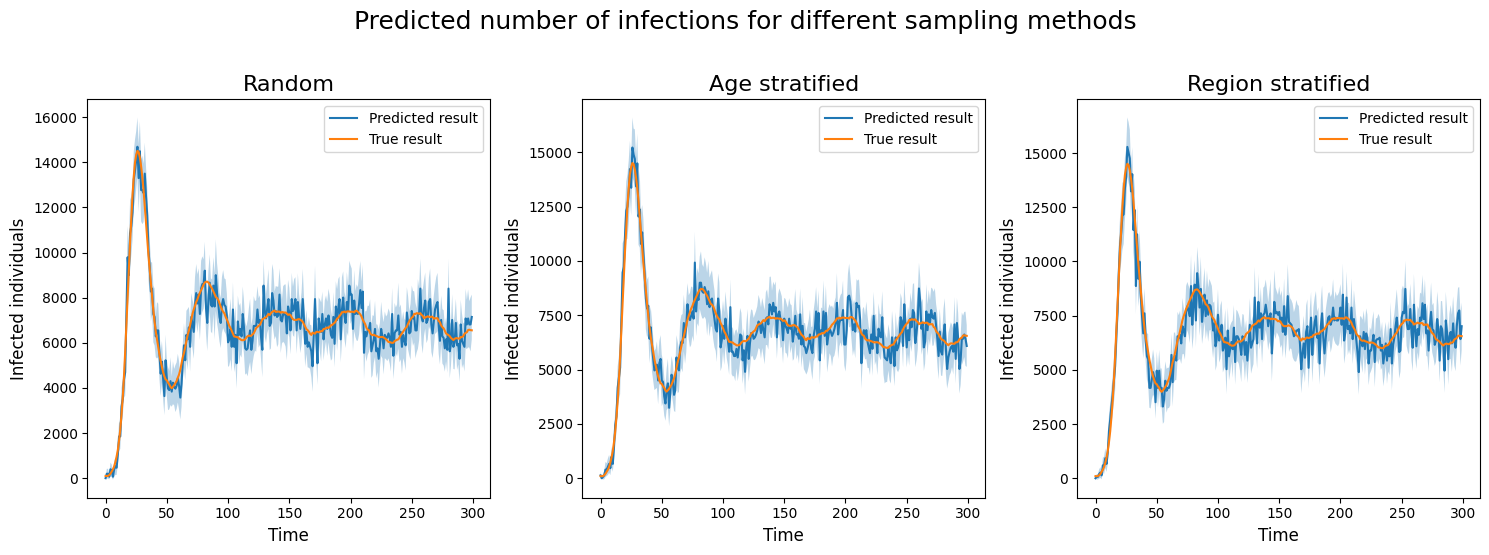

<Figure size 640x480 with 0 Axes>

In [552]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1
axs[0].plot(time_sample, base_pred_avg, label='Predicted result')
axs[0].plot(time_sample, true, label='True result')
axs[0].fill_between(time_sample, base_confidence_interval_lower, base_confidence_interval_upper, alpha=0.3)
axs[0].legend()
axs[0].set_xlabel('Time', fontsize='12')
axs[0].set_ylabel('Infected individuals', fontsize='12')
axs[0].set_title('Random', fontsize='16')

# Plot 2
axs[1].plot(time_sample, age_pred_avg, label='Predicted result')
axs[1].plot(time_sample, true, label='True result')
axs[1].fill_between(time_sample, age_confidence_interval_lower, age_confidence_interval_upper, alpha=0.3)
axs[1].legend()
axs[1].set_xlabel('Time', fontsize='12')
axs[1].set_ylabel('Infected individuals', fontsize='12')
axs[1].set_title('Age stratified', fontsize='16')

# Plot 3
axs[2].plot(time_sample, region_pred_avg, label='Predicted result')
axs[2].plot(time_sample, true, label='True result')
axs[2].fill_between(time_sample, region_confidence_interval_lower, region_confidence_interval_upper, alpha=0.3)
axs[2].legend()
axs[2].set_xlabel('Time', fontsize='12')
axs[2].set_ylabel('Infected individuals', fontsize='12')
axs[2].set_title('Region stratified', fontsize='16')

plt.tight_layout()
plt.suptitle('Predicted number of infections for different sampling methods', y=1.1, fontsize='18')
plt.show()
plt.clf()


Here we are plotting the RMSE for each sampling method for the total, age, and region predictions

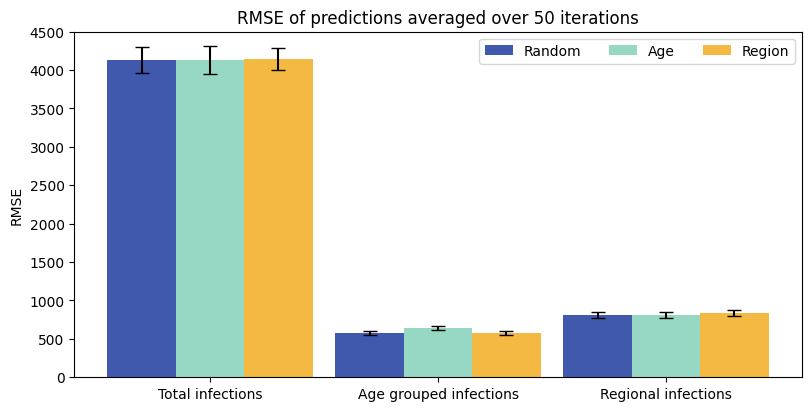

In [506]:
# Make bar chart of average RMSE for base, age, and region predictions
sampling = ("Total infections", "Age grouped infections", "Regional infections")
rmse_values = {
    'Random': (round(np.mean(base_pred_rmse), 2), round(np.mean(base_avg_rmse_age), 2), round(np.mean(base_avg_rmse_region), 2)),
    'Age': (round(np.mean(age_pred_rmse), 2), round(np.mean(age_avg_rmse_age), 2), round(np.mean(age_avg_rmse_region), 2)),
    'Region': (round(np.mean(region_pred_rmse), 2), round(np.mean(region_avg_rmse_age), 2), round(np.mean(region_avg_rmse_region), 2)),
}
error_values = {
    'Random': [np.std(base_pred_rmse), np.mean(base_std_age), np.std(base_std_region)],
    'Age': [np.std(age_pred_rmse), np.mean(age_std_age), np.std(age_std_region)],
    'Region': [np.std(region_pred_rmse), np.mean(region_std_age), np.std(region_std_region)],
}
x = np.arange(len(sampling))  # Label locations
width = 0.3  # Width of the bars
multiplier = 0
colors = ['#4059AD', '#97D8C4', '#F4B942']

fig, ax = plt.subplots(figsize=(8, 4), constrained_layout=True)

for attribute, measurement in rmse_values.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute, color=colors[multiplier])
    for i, rect in enumerate(rects):
        ax.errorbar(rect.get_x() + rect.get_width() / 2, measurement[i], yerr=[error_values[attribute][i]],
                    capsize=5, color='black')
    #ax.bar_label(rects, padding=-15)
    multiplier += 1

ax.set_ylabel('RMSE')
ax.set_title('RMSE of predictions averaged over 50 iterations')
ax.set_xticks(x + width, sampling)
ax.legend(loc='upper right', ncols=3)
ax.set_ylim(0, 4500)

plt.show()

(0.0, 1200.0)

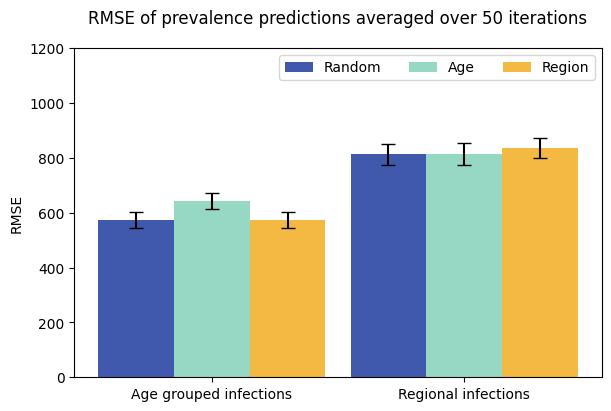

In [556]:
# Make bar chart of average RMSE for base, age, and region predictions
sampling = ("Age grouped infections", "Regional infections")
rmse_values = {
    'Random': (round(np.mean(base_avg_rmse_age), 2), round(np.mean(base_avg_rmse_region), 2)),
    'Age': (round(np.mean(age_avg_rmse_age), 2), round(np.mean(age_avg_rmse_region), 2)),
    'Region': (round(np.mean(region_avg_rmse_age), 2), round(np.mean(region_avg_rmse_region), 2)),
}
error_values = {
    'Random': [np.mean(base_std_age), np.mean(base_std_region)],
    'Age': [np.mean(age_std_age), np.mean(age_std_region)],
    'Region': [np.mean(region_std_age), np.mean(region_std_region)],
}
x = np.arange(len(sampling))  # Label locations
width = 0.3  # Width of the bars
multiplier = 0
colors = ['#4059AD', '#97D8C4', '#F4B942']

fig, ax = plt.subplots(figsize=(6, 4), constrained_layout=True)

for attribute, measurement in rmse_values.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute, color=colors[multiplier])
    for i, rect in enumerate(rects):
        ax.errorbar(rect.get_x() + rect.get_width() / 2, measurement[i], yerr=[error_values[attribute][i]],
                    capsize=5, color='black')
    #ax.bar_label(rects, padding=-15)
    multiplier += 1

ax.set_ylabel('RMSE')
ax.set_title('RMSE of prevalence predictions averaged over 50 iterations', y=1.05)
ax.set_xticks(x + width, sampling)
ax.legend(loc='upper right', ncols=3)
ax.set_ylim(0, 1200)


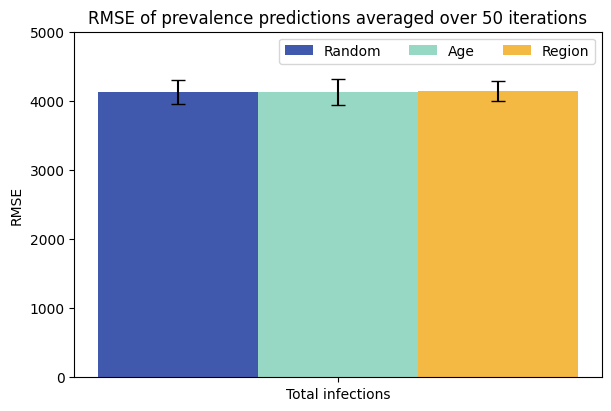

In [551]:
# Make bar plot of these values
fig, ax = plt.subplots(figsize=(6, 4), constrained_layout=True)
x = np.arange(1)  # Label locations
width = 0.1  # Width of the bars
multiplier = 0
colors = ['#4059AD', '#97D8C4', '#F4B942']
plt.bar(x - width, rmse_values['Random'], width, label='Random', color=colors[0])
plt.bar(x, rmse_values['Age'], width, label='Age', color=colors[1])
plt.bar(x + width, rmse_values['Region'], width, label='Region', color=colors[2])

# Add error bars
plt.errorbar(x - width, rmse_values['Random'], yerr=error_values['Random'], fmt='none', color='black', capsize=5)
plt.errorbar(x, rmse_values['Age'], yerr=error_values['Age'], fmt='none', color='black', capsize=5)
plt.errorbar(x + width, rmse_values['Region'], yerr=error_values['Region'], fmt='none', color='black', capsize=5)

plt.ylabel('RMSE')
plt.title('RMSE of prevalence predictions averaged over 50 iterations')
plt.xticks(x, sampling)
plt.legend(loc='upper right', ncols=3)
plt.ylim(0, 5000)
plt.show()

We can see the distribution of individuals by age and region

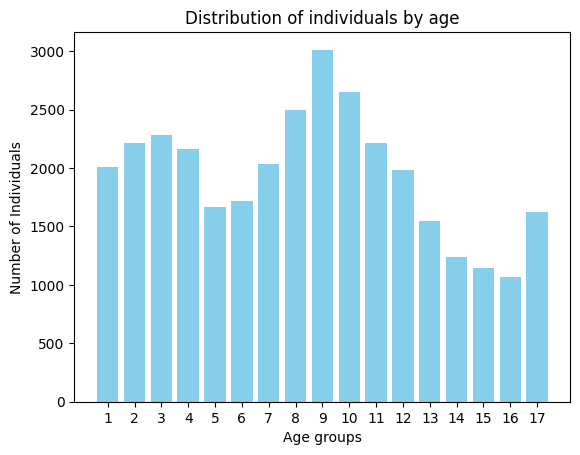

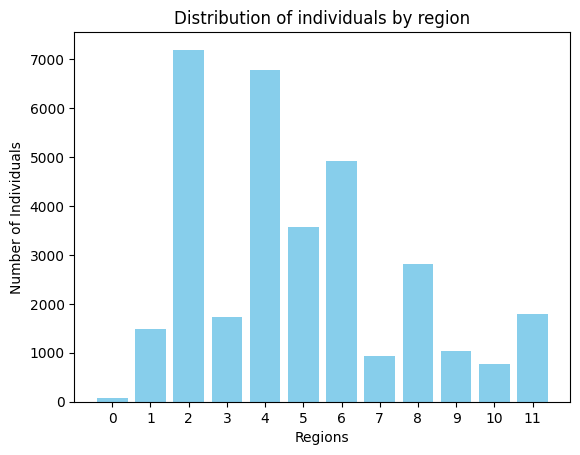

<Figure size 640x480 with 0 Axes>

In [318]:
age_groups = [_+1 for _ in range(len(total_by_age_groups_lists))]
regions = [_ for _ in range(len(total_by_region_lists))]
num_people = total_by_age_groups_lists
num_people_regions = total_by_region_lists

plt.bar(age_groups, num_people, color='skyblue')
plt.xlabel('Age groups')
plt.ylabel('Number of Individuals')
plt.title('Distribution of individuals by age')
plt.xticks(age_groups)
plt.show()
plt.clf()

plt.bar(regions, num_people_regions, color='skyblue')
plt.xlabel('Regions')
plt.ylabel('Number of Individuals')
plt.title('Distribution of individuals by region')
plt.xticks(regions)
plt.show()
plt.clf()

We can also show the distribution of infections over time by age group and region

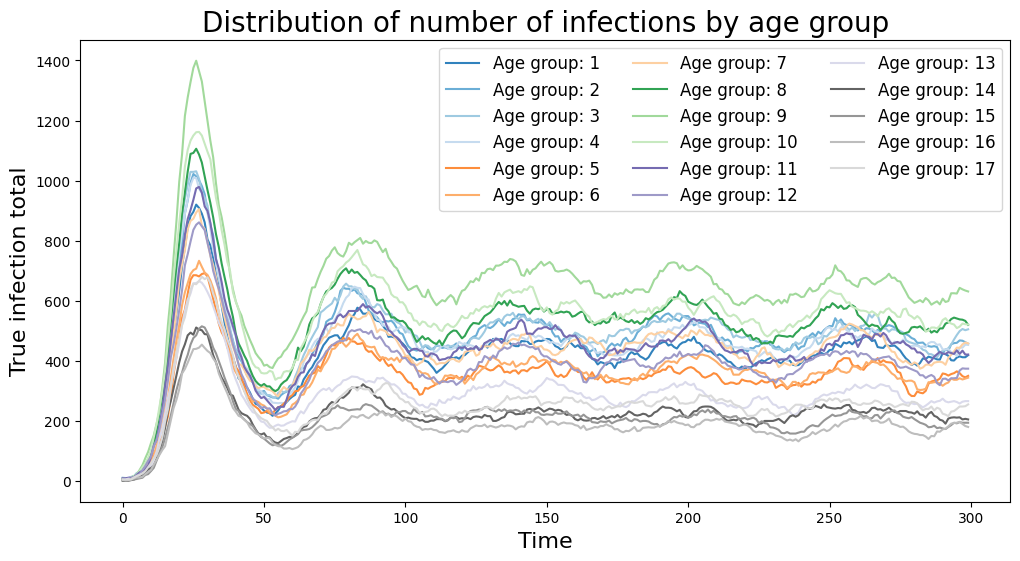

In [579]:
plt.figure(figsize=(12, 6))
cmap = plt.get_cmap('tab20c')
colors = [cmap(i) for i in np.linspace(0, 1, len(true_age_grouped_infections))]
for i, sublist in enumerate(true_age_grouped_lists):
    plt.plot(times, true_age_grouped_lists[i], label=f'Age group: {i+1}', color=colors[i])
plt.xlabel("Time", fontsize=16)
plt.ylabel("True infection total", fontsize=16)
plt.title("Distribution of number of infections by age group", fontsize=20)
plt.legend(fontsize=12, ncol=3)
plt.show()

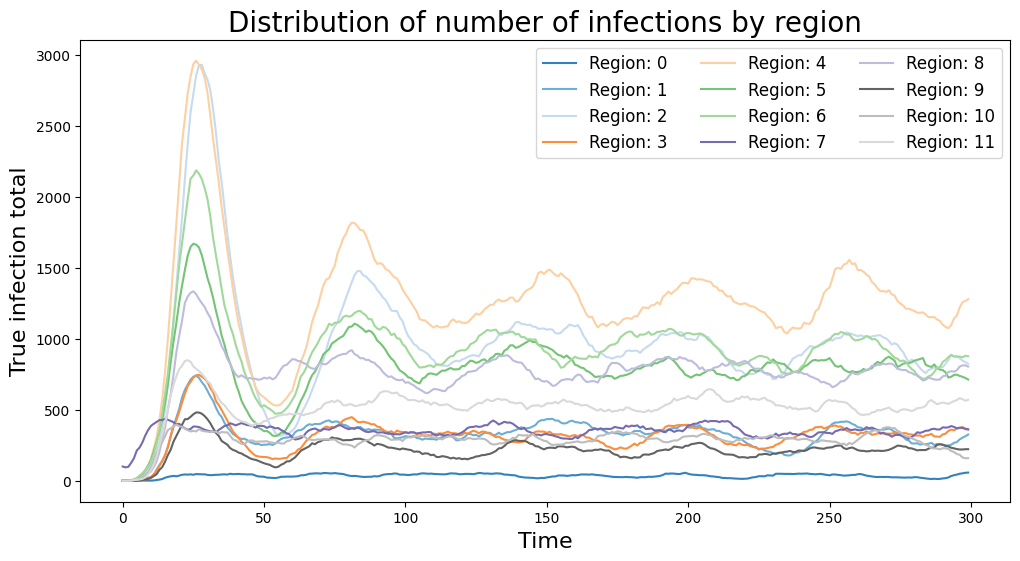

In [580]:
plt.figure(figsize=(12, 6))
cmap = plt.get_cmap('tab20c')
colors = [cmap(i) for i in np.linspace(0, 1, len(true_region_infections))]
for i, sublist in enumerate(true_region_lists):
    plt.plot(times, true_region_lists[i], label=f'Region: {i}', color=colors[i])
plt.xlabel("Time", fontsize=16)
plt.ylabel("True infection total", fontsize=16)
plt.title("Distribution of number of infections by region", fontsize=20)
plt.legend(fontsize=12, ncol=3)
plt.show()